<div style="text-align: center;" >
<h1 style="margin-top: 0.2em; margin-bottom: 0.1em;">SMDA-Project Analysis</h1>
<h4 style="margin-top: 0.7em; margin-bottom: 0.3em; font-style:italic">

</div>
<br>

## Import Libraries and Data

In [1]:
#Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix

I got the results of the current European Championship from the official UEFA website. The data is necessary in order to have it as a comparison value for the true values.

In [2]:
#Creating the true data of the tournament
euro24_results = {
    "Country": ["Spain", "England", "France", "Netherlands", "Germany", "Portugal", "Switzerland", "Turkey",
                "Georgia", "Slovakia", "Belgium", "Slovenia", "Romania", "Austria", "Italy", "Denmark",
                "Croatia", "Poland", "Hungary", "Albania", "Scotland", "Czechia", "Serbia", "Ukraine"],
    "Result": ["Winner", "Final", "Semi Final", "Semi Final", "Quarter Final", "Quarter Final", "Quarter Final", "Quarter Final",
               "Round of 16", "Round of 16", "Round of 16", "Round of 16", "Round of 16", "Round of 16", "Round of 16", "Round of 16",
               "Group", "Group", "Group", "Group", "Group", "Group", "Group", "Group"]
}

#Transform them into a DataFrame
euro24_results = pd.DataFrame(euro24_results)
euro24_results

,Country,Result
0,Spain,Winner
1,England,Final
2,France,Semi Final
3,Netherlands,Semi Final
4,Germany,Quarter Final
5,Portugal,Quarter Final
6,Switzerland,Quarter Final
7,Turkey,Quarter Final
8,Georgia,Round of 16
9,Slovakia,Round of 16


In [3]:
#Load the simulation results from local directory
fifa23_results = pd.read_csv("data/fifa23_results.csv")

chatgpt_results = pd.read_csv("data/chatgpt_results.csv")

gemini_results = pd.read_csv("data/gemini_results.csv")

llama3_results = pd.read_csv("data/llama3_results.csv")

## Labelling of the simulated data

To correctly assign labels to the countries, the dataframe containing all performance scores was first divided into groups.

First, the label "Group" was assigned to the last team in each group. Next, the third-placed countries were considered, with the top four advancing to the next round and the bottom two being eliminated. The elimination or progression of teams was determined based on the probabilities in the "Round of 16" column, ranking the third-placed teams accordingly to decide who advanced.

For the teams that reached the final round, a group of sixteen was formed similarly to the simulate_tournament function. Here, the probabilities of reaching the quarter-finals were considered for each pair of matches, and the team with the higher probability advanced. This process continued through the remainder of the final rounds, with labels assigned accordingly.

First insights have been gained regarding the tournament structure. For example, the Czech Republic achieved very high probabilities because they had a relatively easy tournament compared to other teams.

In [4]:
#Groups of the tournament
groups = {
    "A": ["Germany", "Scotland", "Hungary", "Switzerland"],
    "B": ["Spain", "Croatia", "Italy", "Albania"],
    "C": ["Slovenia", "Denmark", "Serbia", "England"],
    "D": ["Poland", "Netherlands", "Austria", "France"],
    "E": ["Belgium", "Slovakia", "Romania", "Ukraine"],
    "F": ["Türkiye", "Georgia", "Portugal", "Czech Republic"]
}

#Create group specific dataframes for easier labeling
group_dataframes = {}
for group, countries in groups.items():
    group_dataframes[group] = fifa23_results[fifa23_results["Country"].isin(countries)].reset_index(drop=True)

In [5]:
def add_simulated_label(data, group_dataframes):
    """
    This function assigns labels to teams based on their progress in a simulated tournament.
    The labels include: "Group", "Round of 16", "Quarter Final", "Semi Final", "Final", and "Winner".
    
    Parameters:
    data (pd.DataFrame): The main dataframe containing team information and their progression scores.
    group_dataframes (dict): A dictionary where keys are group names and values are dataframes containing teams in those groups.

    Returns:
    pd.DataFrame: The updated dataframe with a new column "Label" indicating the stage reached by each team.
    """
    
    ##################### GROUP LABEL #####################
    
    #Identify the last team in each group and label them "Group"
    for group, group_df in group_dataframes.items():
        last_team = group_df.loc[group_df["Round of 16"].idxmin(), "Country"]
        data.loc[data["Country"] == last_team, "Label"] = "Group"
    
    #Collect all second last teams
    second_last_teams = []
    for group, group_df in group_dataframes.items():
        #Sort the group by "Round of 16" in ascending order
        sorted_group = group_df.sort_values("Round of 16", ascending=False)
        #Get the second last team
        second_last_team = sorted_group.iloc[2]
        second_last_teams.append(second_last_team)
    
    #Convert the list to a DataFrame for easier handling
    second_last_df = pd.DataFrame(second_last_teams)
    
    #Sort the second last teams by "Round of 16" in descending order
    sorted_second_last_df = second_last_df.sort_values("Round of 16", ascending=True)
    
    #Get the last two teams from the sorted list
    last_two_teams = sorted_second_last_df.head(2)
    
    #Label these last two teams as "Group"
    for _, team in last_two_teams.iterrows():
        data.loc[data["Country"] == team["Country"], "Label"] = "Group"
        
    ##################### ROUND OF 16 LABEL #####################
    
    #Determine the teams advancing to the Round of 16
    a1, a2 = group_dataframes["A"].iloc[0]["Country"], group_dataframes["A"].iloc[1]["Country"]
    b1, b2 = group_dataframes["B"].iloc[0]["Country"], group_dataframes["B"].iloc[1]["Country"]
    c1, c2 = group_dataframes["C"].iloc[0]["Country"], group_dataframes["C"].iloc[1]["Country"]
    d1, d2 = group_dataframes["D"].iloc[0]["Country"], group_dataframes["D"].iloc[1]["Country"]
    e1, e2 = group_dataframes["E"].iloc[0]["Country"], group_dataframes["E"].iloc[1]["Country"]
    f1, f2 = group_dataframes["F"].iloc[0]["Country"], group_dataframes["F"].iloc[1]["Country"]
    
    #Determine the best third-placed teams to advance
    third_placed_teams = []
    for group in group_dataframes.values():
        third_placed_teams.append(group.iloc[2])
    
    #Sort the third-placed teams to get the top four
    third_placed_df = pd.DataFrame(third_placed_teams).sort_values(by="Round of 16", ascending=False)
    rd_1, rd_2, rd_3, rd_4 = third_placed_df.iloc[0]["Country"], third_placed_df.iloc[1]["Country"], third_placed_df.iloc[2]["Country"], third_placed_df.iloc[3]["Country"]
    
    #Define the matches for the Round of 16
    round_of_16_pairs = [[a1, c2], [b1, rd_3], [d2, e2], [f1, rd_4], [a2, b2], [c1, rd_2], [e1, rd_1], [d1, f2]]

    #Identify winners of the Round of 16
    round_of_16_winners = []
    for pair in round_of_16_pairs:
        team1, team2 = pair
        team1_qf_score = data.loc[data["Country"] == team1, "Quarter Final"].values[0]
        team2_qf_score = data.loc[data["Country"] == team2, "Quarter Final"].values[0]
        if team1_qf_score > team2_qf_score:
            round_of_16_winners.append(team1)
            data.loc[data["Country"] == team2, "Label"] = "Round of 16"
        else:
            round_of_16_winners.append(team2)
            data.loc[data["Country"] == team1, "Label"] = "Round of 16"
    
    ##################### QUARTER FINAL LABEL #####################
    
    #Define the matches for the Quarter Final
    quarter_final_pairs = [
        [round_of_16_winners[0], round_of_16_winners[1]], 
        [round_of_16_winners[2], round_of_16_winners[3]],
        [round_of_16_winners[4], round_of_16_winners[5]],
        [round_of_16_winners[6], round_of_16_winners[7]]
    ]

    #Identify winners of the Quarter Final
    quarter_final_winners = []
    for pair in quarter_final_pairs:
        team1, team2 = pair
        team1_sf_score = data.loc[data["Country"] == team1, "Semi Final"].values[0]
        team2_sf_score = data.loc[data["Country"] == team2, "Semi Final"].values[0]
        if team1_sf_score > team2_sf_score:
            quarter_final_winners.append(team1)
            data.loc[data["Country"] == team2, "Label"] = "Quarter Final"
        else:
            quarter_final_winners.append(team2)
            data.loc[data["Country"] == team1, "Label"] = "Quarter Final"
    
    ##################### SEMI FINAL LABEL #####################
    
    #Define the matches for the Semi Final
    semi_final_pairs = [
        [quarter_final_winners[0], quarter_final_winners[1]], 
        [quarter_final_winners[2], quarter_final_winners[3]]
    ]

    #Identify winners of the Semi Final
    semi_final_winners = []
    for pair in semi_final_pairs:
        team1, team2 = pair
        team1_f_score = data.loc[data["Country"] == team1, "Final"].values[0]
        team2_f_score = data.loc[data["Country"] == team2, "Final"].values[0]
        if team1_f_score > team2_f_score:
            semi_final_winners.append(team1)
            data.loc[data["Country"] == team2, "Label"] = "Semi Final"
        else:
            semi_final_winners.append(team2)
            data.loc[data["Country"] == team1, "Label"] = "Semi Final"
    
    ##################### FINAL LABEL #####################
    
    #Define the match for the Final
    final_pair = [semi_final_winners[0], semi_final_winners[1]]

    #Identify winner and runner-up of the Final
    team1, team2 = final_pair
    team1_w_score = data.loc[data["Country"] == team1, "Winner"].values[0]
    team2_w_score = data.loc[data["Country"] == team2, "Winner"].values[0]
    if team1_w_score > team2_w_score:
        data.loc[data["Country"] == team1, "Label"] = "Winner"
        data.loc[data["Country"] == team2, "Label"] = "Final"
    else:
        data.loc[data["Country"] == team2, "Label"] = "Winner"
        data.loc[data["Country"] == team1, "Label"] = "Final"
    
    return data


In [6]:
#Apply the labeling function to the simulation results
fifa23_labeled = add_simulated_label(fifa23_results, group_dataframes)
chatgpt_labeled = add_simulated_label(chatgpt_results, group_dataframes)
gemini_labeled = add_simulated_label(gemini_results, group_dataframes)
llama3_labeled = add_simulated_label(llama3_results, group_dataframes)

#Display the labeled fifa23 results as example
fifa23_labeled

,Country,Round of 16,Quarter Final,Semi Final,Final,Winner,Label
0,Spain,92.89,59.26,36.20,22.91,13.51,Winner
1,England,90.54,57.82,34.07,21.12,12.58,Final
2,Italy,86.41,50.54,28.21,16.00,8.65,Quarter Final
3,Germany,83.51,48.74,26.59,15.36,8.57,Quarter Final
4,France,78.59,47.34,26.95,14.32,7.59,Semi Final
5,Czech Republic,87.66,49.46,27.08,13.25,6.79,Semi Final
6,Netherlands,75.65,43.62,24.37,12.40,6.43,Quarter Final
7,Belgium,81.54,42.71,22.65,10.72,5.08,Quarter Final
8,Ukraine,80.25,41.37,21.51,10.04,4.80,Round of 16
9,Hungary,69.01,33.45,15.76,7.62,3.42,Round of 16


In [7]:
chatgpt_labeled

,Country,Round of 16,Quarter Final,Semi Final,Final,Winner,Label
0,France,85.82,56.93,36.61,21.94,13.18,Winner
1,Spain,85.31,53.15,31.34,19.00,10.78,Final
2,England,86.79,53.38,30.53,17.76,10.30,Semi Final
3,Portugal,84.90,48.85,28.98,15.98,8.69,Round of 16
4,Germany,84.59,48.26,27.23,15.16,8.21,Quarter Final
5,Netherlands,74.59,43.79,24.46,12.74,6.70,Semi Final
6,Italy,78.83,44.80,24.14,12.94,6.57,Quarter Final
7,Belgium,82.39,43.89,22.27,10.77,5.08,Quarter Final
8,Croatia,69.47,35.76,18.03,8.83,4.11,Round of 16
9,Switzerland,74.06,36.59,18.40,8.82,3.99,Group


In [8]:
gemini_labeled

,Country,Round of 16,Quarter Final,Semi Final,Final,Winner,Label
0,France,84.03,53.53,32.22,18.90,11.30,Winner
1,Germany,87.30,50.66,28.91,16.95,9.63,Quarter Final
2,Belgium,87.78,52.06,29.78,17.06,9.48,Quarter Final
3,Portugal,87.46,50.95,29.56,16.56,9.33,Final
4,Spain,81.51,49.12,28.60,15.72,8.61,Round of 16
5,England,82.19,46.23,25.17,13.70,7.20,Semi Final
6,Italy,73.97,40.14,21.28,11.06,5.49,Quarter Final
7,Netherlands,72.44,40.02,21.32,11.13,5.46,Semi Final
8,Croatia,74.50,41.00,21.65,11.01,5.41,Round of 16
9,Serbia,69.09,33.13,15.57,7.66,3.41,Group


In [9]:
llama3_labeled

,Country,Round of 16,Quarter Final,Semi Final,Final,Winner,Label
0,England,89.15,54.30,31.56,18.41,10.24,Winner
1,France,85.99,52.16,30.98,17.17,9.98,Semi Final
2,Spain,85.93,52.95,29.74,17.08,9.73,Final
3,Germany,87.58,49.84,29.17,16.58,9.15,Quarter Final
4,Italy,83.25,49.20,27.73,15.48,8.59,Quarter Final
5,Belgium,84.09,49.35,28.01,15.37,8.12,Quarter Final
6,Portugal,84.29,48.84,27.75,14.70,8.09,Round of 16
7,Denmark,79.98,40.97,20.79,10.68,5.26,Round of 16
8,Netherlands,78.16,43.26,22.71,11.07,5.14,Semi Final
9,Serbia,74.05,36.02,16.47,7.83,3.71,Group


## Calculate metrics for result comparision


Suitable metrics for classification problems include precision, recall, and accuracy. A confusion matrix was also generated for visualization. Additionally, a spearman correlation and permutation test were calculated to statistically validate the results.

In [10]:
def spearman_correlation(df_true, df_pred):
    """
    Calculate Spearman's rank-order correlation coefficient to evaluate the relationship between true results and predicted labels.

    Parameters:
    df_true (pd.DataFrame): DataFrame containing the true results with columns ["Country", "Result"]
    df_pred (pd.DataFrame): DataFrame containing the predicted labels with columns ["Country", "Label"]

    Returns:
    Spearman's rank-order correlation coefficient and p-value.
    """
    
    # Merge the true and predicted DataFrames on the 'Country' column
    merged_df = pd.merge(df_true, df_pred, on="Country")
    
    # Calculate Spearman's correlation coefficient
    correlation, p_value = spearmanr(merged_df["Result"], merged_df["Label"])
    
    # Print the Spearman's correlation results
    print(f"Spearman's Correlation Coefficient: {correlation}")
    print(f"P-value: {p_value}")
    
    return correlation, p_value

In [11]:
def permutation_test(df_true, n_permutations=10000):
    """
    Perform a permutation test on the given Euro24 results, calculating the accuracy,
    precision, and recall for each permutation.
    
    Parameters:
    df_true (pd.DataFrame): A DataFrame with 'Country' and 'Result' columns representing the true results.
    n_permutations (int): The number of permutations to perform.
    
    Returns:
    tuple: Three lists containing the accuracy, precision, and recall scores for each permutation.
    """
    # Define a simple mapping from the string results to numeric for metrics calculation
    result_mapping = {
        "Winner": 1,
        "Final": 2,
        "Semi Final": 3,
        "Quarter Final": 4,
        "Round of 16": 5,
        "Group": 6
    }
    
    # Map the true results to numeric values
    true_values = df_true["Result"].map(result_mapping)
    
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    
    for _ in range(n_permutations):
        # Permute the results
        permuted_results = df_true.copy()
        permuted_results["Result"] = np.random.permutation(permuted_results["Result"])
        permuted_values = permuted_results["Result"].map(result_mapping)
        
        # Calculate accuracy, precision, and recall
        accuracy = accuracy_score(true_values, permuted_values)
        precision = precision_score(true_values, permuted_values, average="macro")
        recall = recall_score(true_values, permuted_values, average="macro")
        
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
    
    return accuracy_scores, precision_scores, recall_scores

In [12]:
def calculate_metrics(df_true, df_pred):
    """
    Calculate precision, recall, and accuracy between the predicted labels and true results.

    Parameters:
    df_true (pd.DataFrame): DataFrame containing the true results with columns ["Country", "Result"]
    df_pred (pd.DataFrame): DataFrame containing the predicted labels with columns ["Country", "Label"]

    The function maps the categorical results into numerical labels and computes the precision, recall,
    and accuracy scores.

    Returns:
    Precision, Recall and Accuracy scores
    """
    
    # Create a mapping of results to numerical values
    result_mapping = {"Group": 0, "Round of 16": 1, "Quarter Final": 2, "Semi Final": 3, "Final": 4, "Winner": 5}

    # Map the labels and results to numerical values
    df_pred["Label_num"] = df_pred["Label"].map(result_mapping)
    df_true["Result_num"] = df_true["Result"].map(result_mapping)

    # Merge the DataFrames on Country
    merged_df = pd.merge(df_pred[["Country", "Label_num"]], df_true[["Country", "Result_num"]], on="Country")
    
    # Labels for the metrics
    labels = ["Group", "Round of 16", "Quarter Final", "Semi Final", "Final", "Winner"]
    
    # Output sklearn classification report
    report = classification_report(merged_df["Result_num"], merged_df["Label_num"], target_names=labels, output_dict=True)
    
    # Extract weighted precision, recall and accuracy from the classification report
    pred_precision = report["weighted avg"]["precision"]
    pred_recall = report["weighted avg"]["recall"]
    pred_accuracy = report["accuracy"]

    # Print the classification report for reference
    print(classification_report(merged_df["Result_num"], merged_df["Label_num"], target_names=labels))

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(merged_df["Result_num"], merged_df["Label_num"])

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    
    # Calculate permutation test
    accuracy_scores, precision_scores, recall_scores = permutation_test(df_true)

    # Calculate p-values
    p_value_accuracy = np.mean(np.array(accuracy_scores) >= pred_accuracy)
    p_value_precision = np.mean(np.array(precision_scores) >= pred_precision)
    p_value_recall = np.mean(np.array(recall_scores) >= pred_recall)

    # Plot the results with the average line and display p-values
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.hist(accuracy_scores, bins=30, color="darkblue", edgecolor="black")
    plt.axvline(pred_accuracy, color="red", linestyle="dashed", linewidth=2)
    plt.title(f"Accuracy Scores\np-value = {p_value_accuracy:.4f}")
    plt.xlabel("Accuracy")
    plt.ylabel("Frequency")

    plt.subplot(1, 3, 2)
    plt.hist(precision_scores, bins=30, color="skyblue", edgecolor="black")
    plt.axvline(pred_precision, color="red", linestyle="dashed", linewidth=2)
    plt.title(f"Precision Scores\np-value = {p_value_precision:.4f}")
    plt.xlabel("Precision")
    plt.ylabel("Frequency")

    plt.subplot(1, 3, 3)
    plt.hist(recall_scores, bins=30, color="cornflowerblue", edgecolor="black")
    plt.axvline(pred_recall, color="red", linestyle="dashed", linewidth=2)
    plt.title(f"Recall Scores\np-value = {p_value_recall:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

In [13]:
def summary_metrics(name, df_true, df_pred):
    """
    Print a summary of metrics including Chi-Square test results and precision, recall, accuracy metrics.

    Parameters:
    name (str): The name of the dataset or test being evaluated.
    df_true (pd.DataFrame): DataFrame containing the true results with columns ["Country", "Result"]
    df_pred (pd.DataFrame): DataFrame containing the predicted labels with columns ["Country", "Label"]

    Returns:
    A summary of metrics including Chi-Square test results, precision, recall, accuracy scores and confusion matrix.
    """
    
    # Print the name of the dataset or test
    print(f"Metrics for {name}")
    print("----------------------------")
    
    # Perform and print the Chi-Square test results
    spearman_correlation(df_true, df_pred)  
    print("\n")
    
    # Calculate and print precision, recall, and accuracy metrics
    calculate_metrics(df_true, df_pred)


Metrics for FIFA23
----------------------------
Spearman's Correlation Coefficient: 0.28179891741423685
P-value: 0.20389292505502626


               precision    recall  f1-score   support

        Group       0.38      0.43      0.40         7
  Round of 16       0.29      0.25      0.27         8
Quarter Final       0.25      0.33      0.29         3
   Semi Final       1.00      0.50      0.67         2
        Final       1.00      1.00      1.00         1
       Winner       1.00      1.00      1.00         1

     accuracy                           0.41        22
    macro avg       0.65      0.59      0.60        22
 weighted avg       0.44      0.41      0.41        22



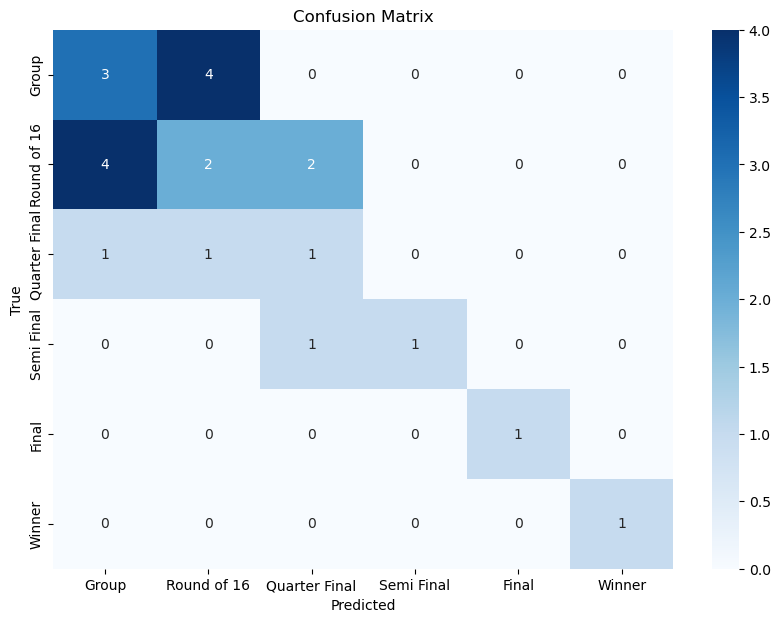

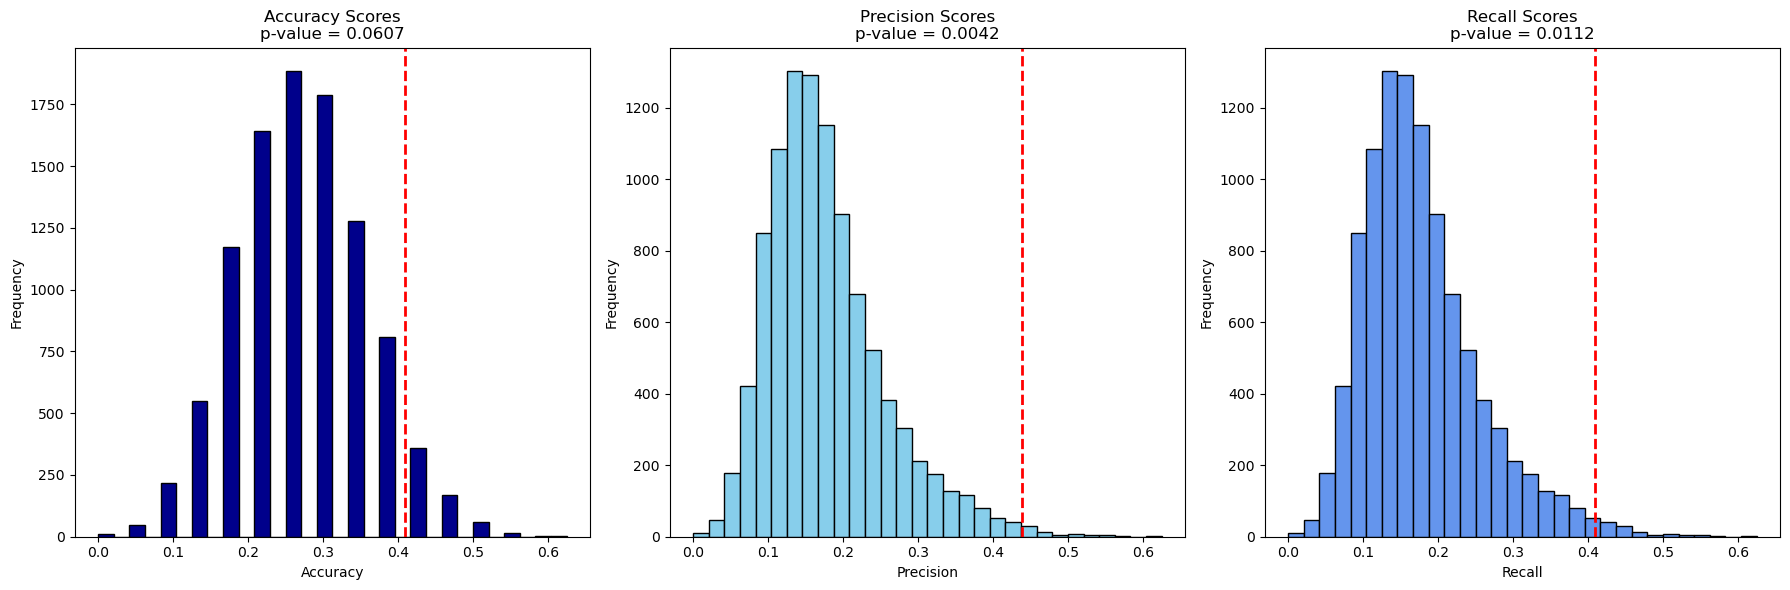

In [14]:
summary_metrics("FIFA23", euro24_results, fifa23_labeled)

Metrics for ChatGPT
----------------------------
Spearman's Correlation Coefficient: -0.07866627147472369
P-value: 0.7278555859192034


               precision    recall  f1-score   support

        Group       0.38      0.43      0.40         7
  Round of 16       0.33      0.25      0.29         8
Quarter Final       0.25      0.33      0.29         3
   Semi Final       0.50      0.50      0.50         2
        Final       0.00      0.00      0.00         1
       Winner       0.00      0.00      0.00         1

     accuracy                           0.32        22
    macro avg       0.24      0.25      0.25        22
 weighted avg       0.32      0.32      0.32        22



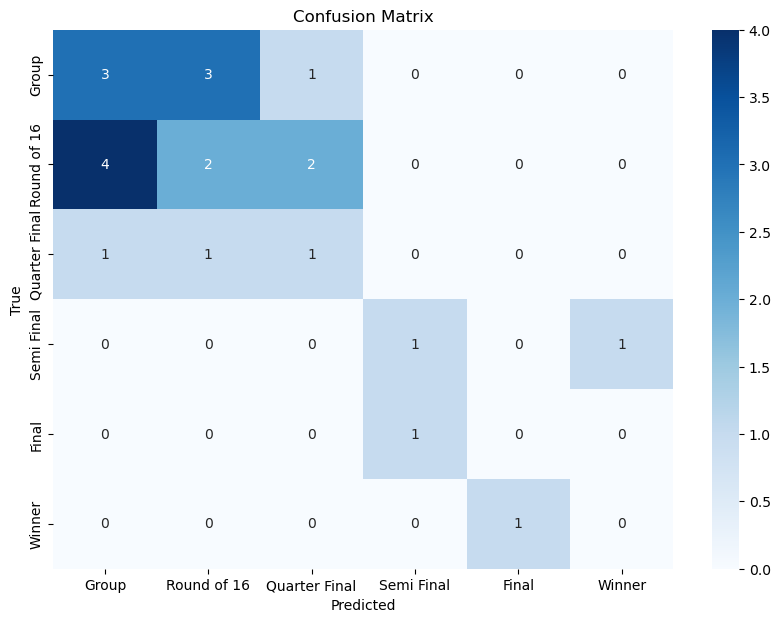

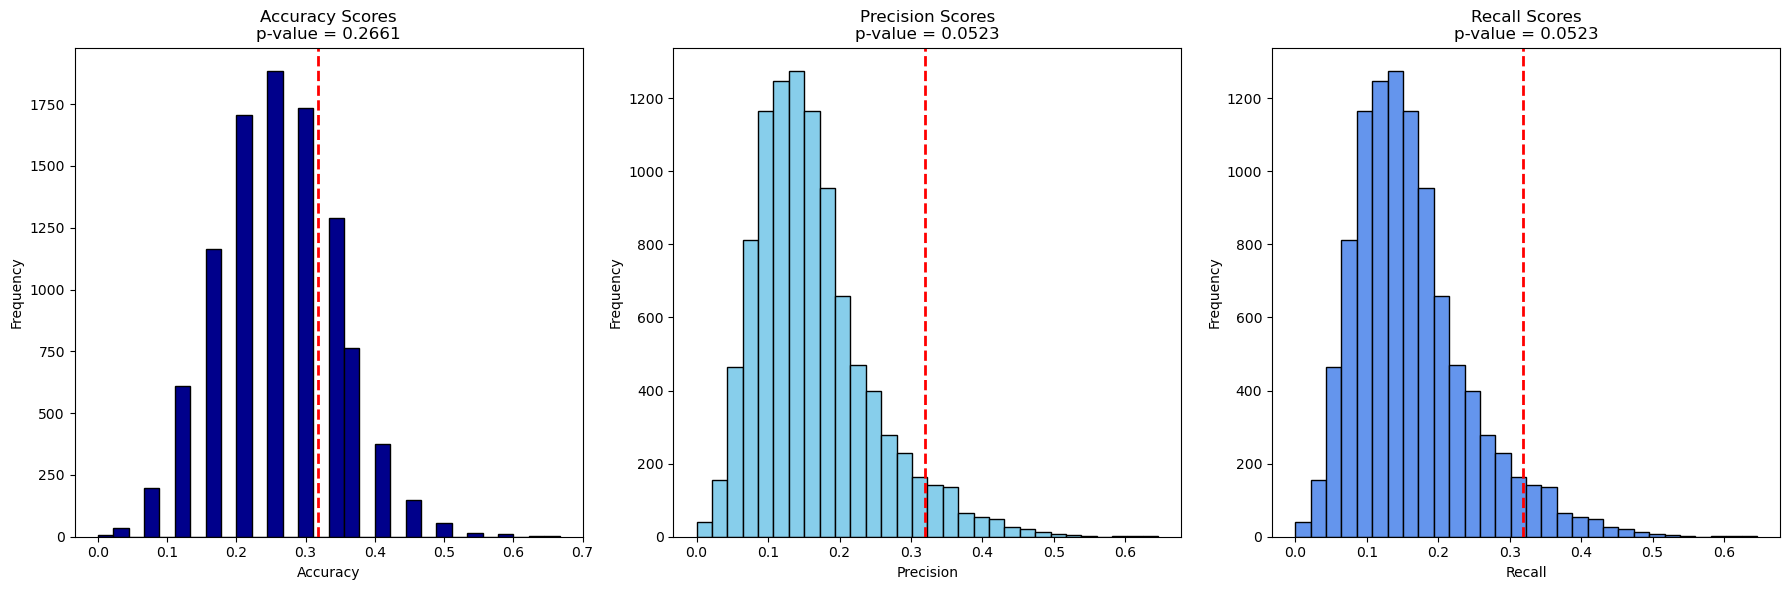

In [15]:
summary_metrics("ChatGPT", euro24_results, chatgpt_labeled)

Metrics for Gemini
----------------------------
Spearman's Correlation Coefficient: 0.11039360393603935
P-value: 0.6247944769712461


               precision    recall  f1-score   support

        Group       0.38      0.43      0.40         7
  Round of 16       0.29      0.25      0.27         8
Quarter Final       0.33      0.33      0.33         3
   Semi Final       0.50      0.50      0.50         2
        Final       0.00      0.00      0.00         1
       Winner       0.00      0.00      0.00         1

     accuracy                           0.32        22
    macro avg       0.25      0.25      0.25        22
 weighted avg       0.31      0.32      0.32        22



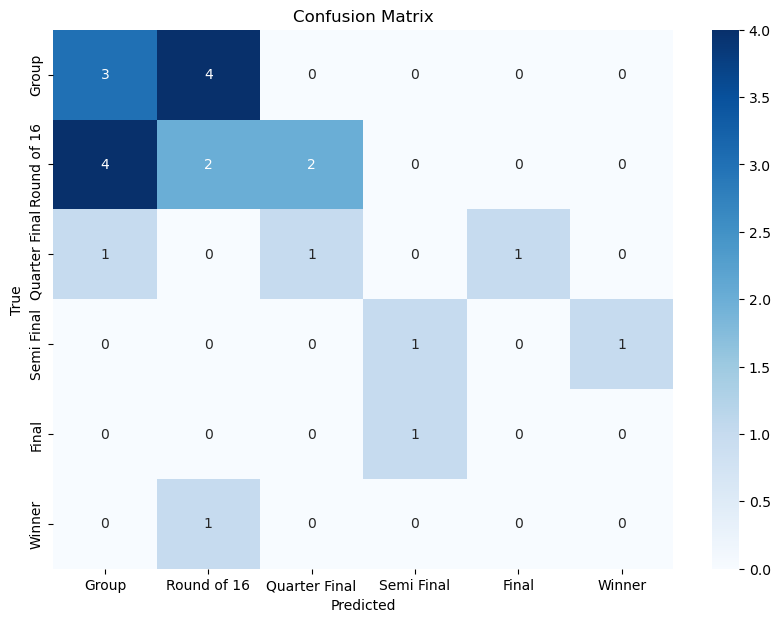

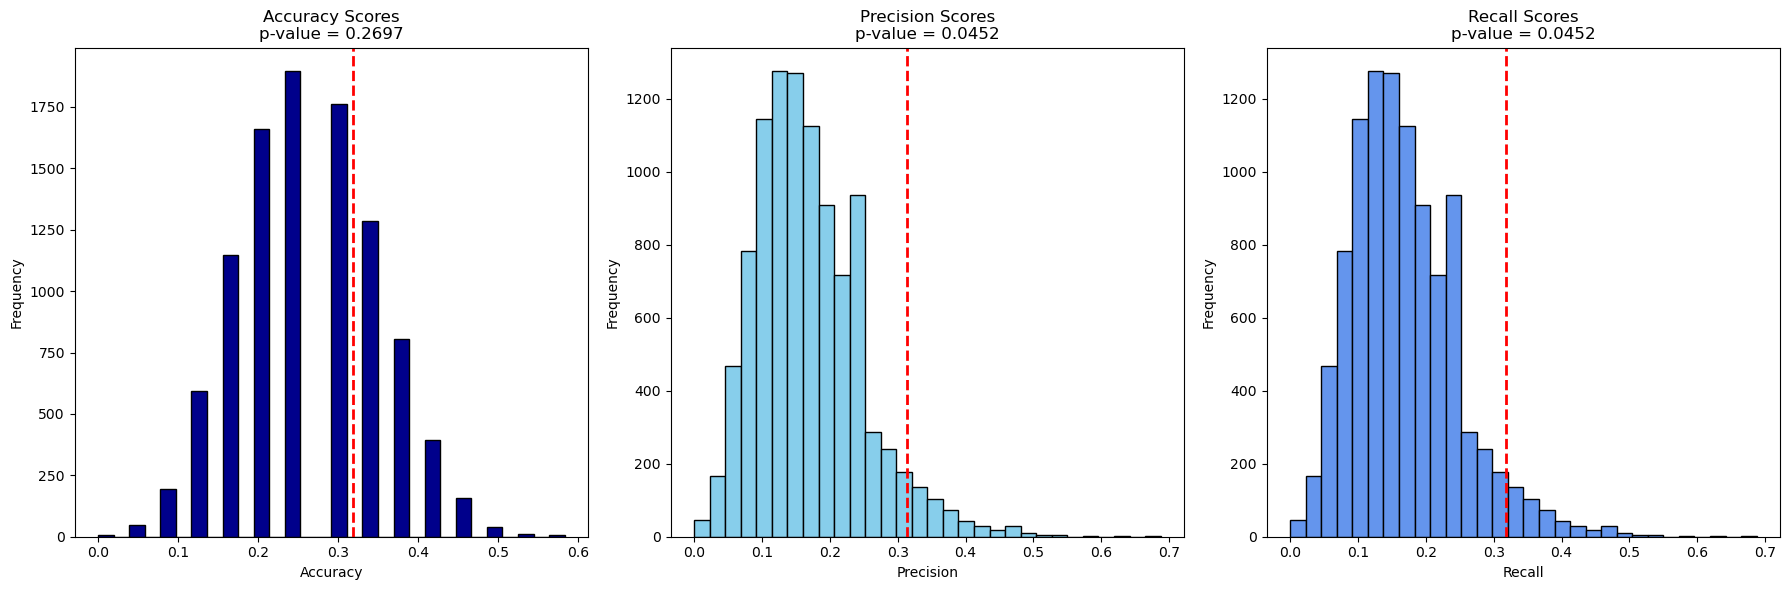

In [16]:
summary_metrics("Gemini", euro24_results, gemini_labeled)

Metrics for Llama3
----------------------------
Spearman's Correlation Coefficient: -0.14698646986469863
P-value: 0.5139210485700241


               precision    recall  f1-score   support

        Group       0.38      0.43      0.40         7
  Round of 16       0.29      0.25      0.27         8
Quarter Final       0.33      0.33      0.33         3
   Semi Final       1.00      1.00      1.00         2
        Final       0.00      0.00      0.00         1
       Winner       0.00      0.00      0.00         1

     accuracy                           0.36        22
    macro avg       0.33      0.34      0.33        22
 weighted avg       0.36      0.36      0.36        22



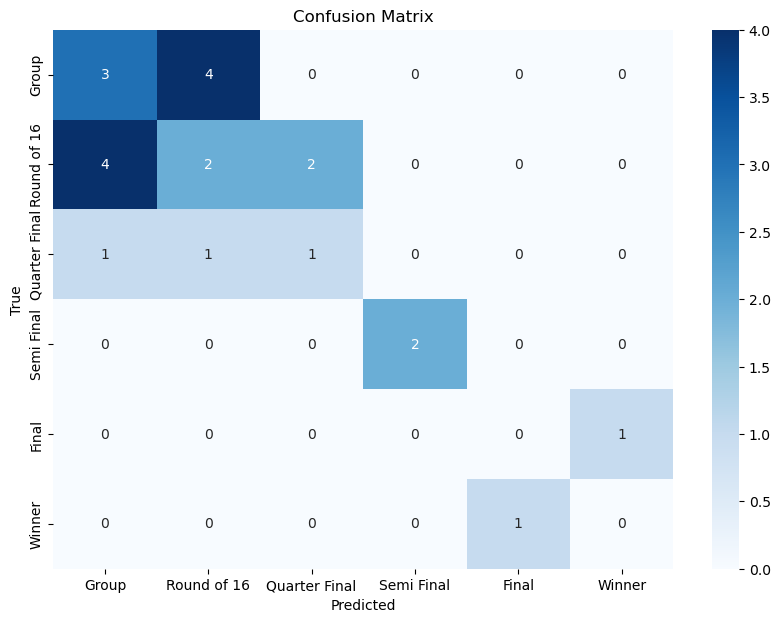

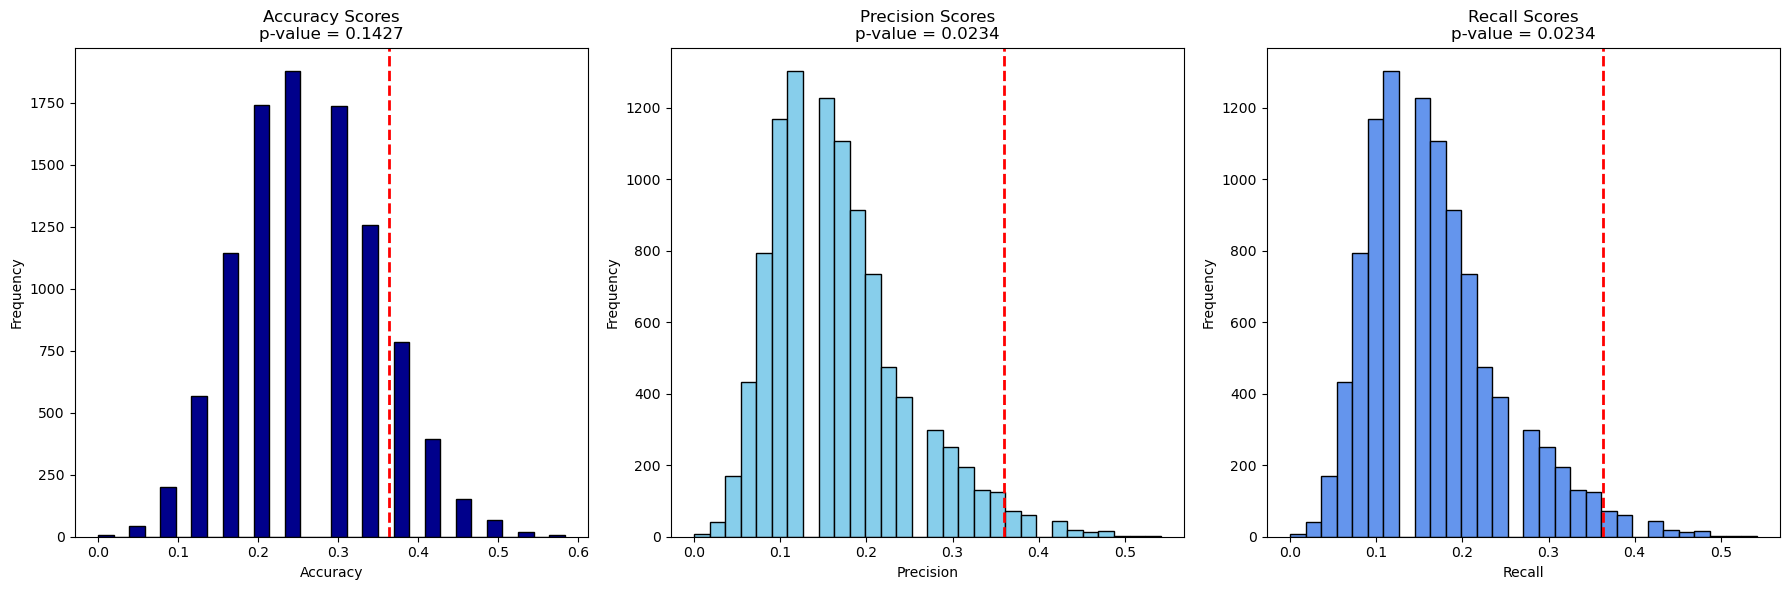

In [17]:
summary_metrics("Llama3", euro24_results, llama3_labeled)